In [1]:
# import matplotlib.pyplot as plt
# import numpy as np
from scipy.stats import skewnorm
# import tensorflow as tf

# # Define the number of samples, the location, the scale, and the skewness
# num_samples = 10000
# mu_data = 0.0  # location (mean) 
# sd_data = 1.0  # scale (standard deviation) 
# alpha_data = 3.0  # skewness (negative value means left skew, positive means right skew)

# # Generate samples from the skew normal distribution
# dist = skewnorm(alpha_data, mu_data, sd_data)
# samples = dist.rvs(num_samples)
# plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')
# xmin, xmax = plt.xlim()
# # xmin = xmin + 1/7 * (xmax - xmin)
# x = np.linspace(xmin, xmax, 1000)
# p = skewnorm.pdf(x, alpha_data, mu_data, sd_data)
# plt.plot(x, p, 'k', linewidth=2)
# x_values = x 
# y_values = p
# plt.show()

In [2]:
import tensorflow as tf

def skew_normal_pdf(x, location=0.0, scale=1.0, alpha=0.0):
    """
    Compute the PDF of the skew normal distribution.
    
    Parameters:
    - x: The points at which to evaluate the PDF.
    - location: The location parameter (mu) of the distribution.
    - scale: The scale parameter (sigma) of the distribution.
    - alpha: The skewness parameter of the distribution.
    
    Returns:
    - The PDF values of the skew normal distribution.
    """
    # Standardize the input
    t = (x - location) / scale
    
    # The standard normal PDF
    phi_x = tf.exp(-0.5 * tf.square(t)) / (tf.sqrt(2.0 * np.pi))
    
    # The standard normal CDF
    Phi_x = 0.5 * (1.0 + tf.math.erf(alpha * t / tf.sqrt(2.0)))
    
    # The skew normal PDF
    skew_pdf = 2.0 * phi_x * Phi_x
    
    return skew_pdf / scale  # Adjust for the scale

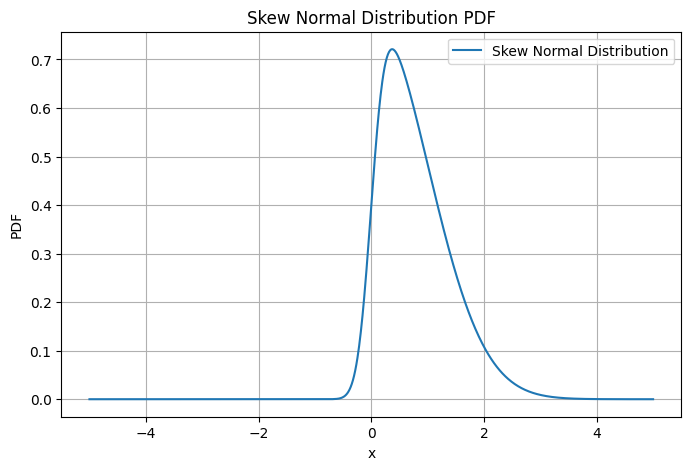

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming you have defined the skew_normal_pdf function as provided earlier

# Example usage:
x_values = tf.linspace(-5.0, 5.0, num=1000)  # More points for a smoother plot
y_values = skew_normal_pdf(x_values, location=0.0, scale=1.0, alpha=5.0)

# Convert to a numpy array for plotting
x_values_numpy = x_values.numpy()
y_values_numpy = y_values.numpy()

# Plotting the skew normal distribution
plt.figure(figsize=(8, 5))
plt.plot(x_values_numpy, y_values_numpy, label='Skew Normal Distribution')
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Skew Normal Distribution PDF')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer='he_normal')
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

In [17]:
# def skew_norm_pdf(x, location, scale, shape):
#     # Standardize the input
#     t = (x - location) / scale

#     # PDF of the standard normal distribution
#     pdf = tf.exp(-t**2 / 2) / np.sqrt(2*np.pi)

#     # CDF of the standard normal distribution
#     cdf = 0.5 * (1 + tf.math.erf(shape * t / np.sqrt(2)))

#     return 2 * pdf * cdf


class OutputNeuron(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        x, mu, sd, alpha = inputs
        # x = tf.expand_dims(x, axis=-1)
        return skew_normal_pdf(x, mu, sd, alpha)

In [18]:
class SNRegressor(tf.keras.Model):
    def __init__(self, x, **kwargs):
        super().__init__(**kwargs)
        self.denseBlock1 = MyDense(64, activation='relu')
        self.denseBlock2 = MyDense(64, activation='relu')
        self.mu = MyDense(1)
        self.sd = MyDense(1, activation='softplus')
        self.alpha = MyDense(1)
        self.outputNeuron = OutputNeuron()
        self.x = x
        # self.out = tf.keras.layers.Dense(output_dim)

    def call(self, input):
        Z = self.denseBlock1(input)
        Z = self.denseBlock2(Z)
        mu = self.mu(Z)
        sd = self.sd(Z) + tf.keras.backend.epsilon()
        # print(sd)
        alpha = self.alpha(Z)
        return self.outputNeuron([self.x, mu, sd, alpha])
    
    def get_params(self, input):
        Z = self.denseBlock1(input)
        Z = self.denseBlock2(Z)
        mu = self.mu(Z)
        sd = self.sd(Z)
        alpha = self.alpha(Z)
        return mu, sd, alpha

In [19]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_values_reshaped = x_values.reshape(-1,1)
# y_values_reshaped = y_values.reshape(-1,1)
# X_train_scaled = scaler.fit_transform(x_values_reshaped)

import tensorflow as tf

# Assuming x_values and y_values are TensorFlow tensors
# Reshape x_values to have a single column
x_values_reshaped = tf.reshape(x_values, shape=(-1, 1))

# Reshape y_values to have a single column
y_values_reshaped = tf.reshape(y_values, shape=(-1, 1))

# Now you can proceed with scaling using the StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Convert the tensors to numpy arrays before scaling
X_train_scaled = scaler.fit_transform(x_values_reshaped.numpy())


In [20]:
# tf.keras.utils.set_random_seed(42)
model = SNRegressor(x_values)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_scaled, y_values_reshaped, epochs=10, batch_size=2)
# model.summary()

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 832us/step - accuracy: 0.2650 - loss: 0.0387
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.3391 - loss: 0.0363
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.3517 - loss: 0.0384
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.3670 - loss: 0.0312
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.3801 - loss: 0.0309
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.3520 - loss: 0.0357
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.3905 - loss: 0.0319
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.4072 - loss: 0.0324
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.3983 - loss: 0.0333
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.3945 - loss: 0.0387


In [21]:
mu, sd, alpha = model.get_params(X_train_scaled)

In [22]:
print('mu:', tf.reduce_mean(mu))
print('sd:', tf.reduce_mean(sd))
print('alpha:', tf.reduce_mean(alpha))

mu: tf.Tensor(-26.45243, shape=(), dtype=float32)
sd: tf.Tensor(23.226257, shape=(), dtype=float32)
alpha: tf.Tensor(-10.102753, shape=(), dtype=float32)


In [23]:
predictions = skewnorm.pdf(x_values, np.mean(alpha), np.mean(mu), np.mean(sd))

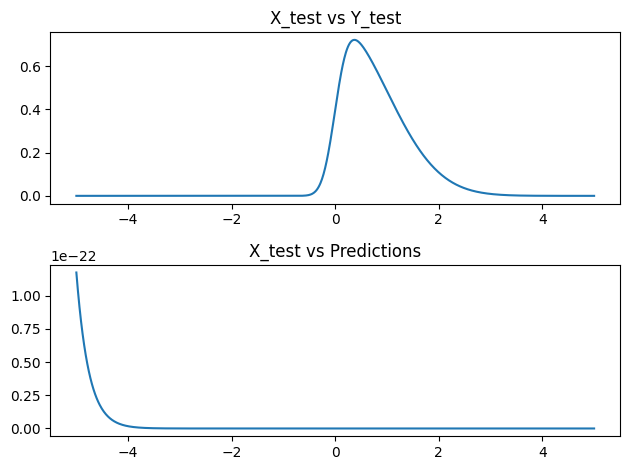

In [24]:
plt.figure()
# Create the first subplot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(x_values, y_values)
plt.title('X_test vs Y_test')

# Create the second subplot
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.plot(x_values, predictions)
plt.title('X_test vs Predictions')

# Display the plots
plt.tight_layout()
plt.show()

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from scipy.stats import skewnorm

# Function to generate x and y coordinates from a skew normal distribution
def generate_skewnormal_data(num_samples, num_data_points):
    mu = np.random.uniform(-5, 5, num_samples)
    sd = np.random.uniform(0.5, 2, num_samples)
    alpha = np.random.uniform(-5, 5, num_samples)
    x_coords = np.linspace(-10, 10, num_data_points)
    y_coords = np.array([skewnorm.pdf(x_coords, a=a, loc=m, scale=s) for a, m, s in zip(alpha, mu, sd)])
    return x_coords, y_coords

# Simulate dataset
num_samples = 1000
num_data_points = 100  # Number of x-values (and corresponding y-values)
x_coords, y_data = generate_skewnormal_data(num_samples, num_data_points)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.tile(x_coords, (num_samples, 1)), y_data, test_size=0.2, random_state=42)

# Define the neural network architecture
model = models.Sequential([
    layers.Input(shape=(num_data_points,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_data_points)  # Output layer with num_data_points units for the y coordinates
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# Predict y coordinates for the test set
y_pred = model.predict(X_test)

# Display true vs predicted y coordinates for the first sample
print(f"True y coordinates: {y_test[0][:10]}")
print(f"Predicted y coordinates: {y_pred[0][:10]}")


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1257 - val_loss: 0.0604
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0372 - val_loss: 0.0194
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0189
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - val_loss: 0.0185
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0181
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - val_loss: 0.0178
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - val_loss: 0.0174
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - val_loss: 0.0171
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - val_loss: 0.0169
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - val_loss: 0.0167
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0165
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from scipy.stats import skewnorm

# Custom layer to output skew normal distribution parameters
class SkewNormalParameterLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(SkewNormalParameterLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SkewNormalParameterLayer, self).build(input_shape)

    def call(self, x):
        mu = x[:, 0]
        sd = tf.math.softplus(x[:, 1])  # Ensure sd is positive
        alpha = x[:, 2]  # Shape parameter
        return mu, sd, alpha

# Custom loss function
def negative_log_likelihood(y_true, y_pred):
    mu, sd, alpha = y_pred
    # Calculate the negative log likelihood of the skew normal distribution
    nll = -tf.reduce_mean(skewnorm.logpdf(y_true, alpha, loc=mu, scale=sd))
    return nll

# Define the model
input_shape = 10  # Replace with the actual number of features in your input data
model = keras.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3),  # Output layer for mu, sd, and alpha
    SkewNormalParameterLayer()
])

# Compile the model
model.compile(optimizer='adam', loss=negative_log_likelihood)

# Example data
X_train = np.random.normal(size=(1000, input_shape))  # Your input features
y_train = skewnorm.rvs(a=5, loc=10, scale=2, size=1000)  # Your target values

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Predict the parameters for new data
X_new = np.random.normal(size=(100, input_shape))  # New input features
mu_pred, sd_pred, alpha_pred = model.predict(X_new)

# Sample from the predicted skew normal distribution
y_pred = skewnorm.rvs(a=alpha_pred, loc=mu_pred, scale=sd_pred)



Epoch 1/100


OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.

In [9]:
import tensorflow as tf
import numpy as np
from scipy.stats import skewnorm

# Define the skew normal PDF function
def skew_normal_pdf(x, location, scale, skewness):
    # t = (x - location) / scale
    # return (2 / scale) * norm.pdf(t) * norm.cdf(skewness * t)
    return skewnorm.pdf(x=x, a=skewness, loc=location, scale=scale)

# Define the negative log likelihood function for the skew normal distribution
def negative_log_likelihood(data, location, scale, skewness):
    # Calculate the PDF values for the data points
    pdf_values = skew_normal_pdf(data, location, scale, skewness)
    
    # Calculate the log of the PDF values
    log_pdf_values = tf.math.log(pdf_values)
    
    # Sum the log PDF values and negate
    nll = -tf.reduce_sum(log_pdf_values)
    return nll

# Assuming we have a set of data points
data = tf.constant([1.0, 2.0, 3.0], dtype=tf.float32)

# Parameters of the skew normal distribution
location = tf.constant(0.0, dtype=tf.float32)  # xi
scale = tf.constant(1.0, dtype=tf.float32)     # omega
skewness = tf.constant(0.0, dtype=tf.float32)  # alpha

# Calculate the negative log likelihood
nll = negative_log_likelihood(data, location, scale, skewness)

# Evaluate the NLL
print("Negative Log Likelihood:", nll.numpy())


Negative Log Likelihood: 9.756815599614018


In [10]:
import numpy as np
from scipy.stats import skewnorm

# Parameters of the skew normal distribution
location = 0.0  # xi (location)
scale = 1.0     # omega (scale)
skewness = 0.0  # alpha (skewness)

# Create a skew normal distribution object
skew_normal_dist = skewnorm(skewness, loc=location, scale=scale)

# Data points for which to calculate the log PDF
data = np.array([1.0, 2.0, 3.0])

# Calculate the log PDF
log_pdf_values = skew_normal_dist.logpdf(data)

# Print the log PDF values
print("Log PDF values:", log_pdf_values)


Log PDF values: [-1.41893853 -2.91893853 -5.41893853]
